In [3]:
import scipy.io as sci
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt

### Separate based on response (flash first or beep first)

In [4]:
resppath = 'StabilityofPCommonData/NumerosityTaskUnformatted/*.mat'
respfiles = np.array(glob.glob(resppath))
datapath = 'StabilityofPCommonData/NumerosityTaskData/*.mat'
datafiles = np.array(glob.glob(datapath))

In [5]:
# filenames for f or b responses
respf = np.empty((1, 1))
respb = np.empty((1, 1))
for names in respfiles:
    mat = sci.loadmat(names)
    resp = mat['respCode']
    if(resp == "f"):
        respf = np.append(respf, names)
    else:
        respb = np.append(respb, names)
respf = respf[1:]
respb = respb[1:]

In [6]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexf = list()
c = 0
for x in respfiles:
    if x in respf:
        indexf.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
dataf = datafiles[indexf]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexf = np.delete(indexf, missing)

### Extract trial data and response times for flash trials

In [7]:
# further subset into flash reported and insert indices for subject id  
dataf = datafiles[indexf]

subjidf = np.array([2,5,7,7,11,11,12,12,15,15,19,20,20,23,28,31,32,32,35,36,37,37,40,
                   40,41,41,42,50,50,53,53,54,54,57,57,60,60,61,61,64])
trialsf = np.empty((1,5))
for i in np.arange(0, len(dataf)):
    mat = sci.loadmat(dataf[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidf[i]), axis=1)
    trialsf = np.vstack((trialsf, arr))
trialsf = trialsf[1:]
print(len(trialsf))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsf:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsf = np.insert(trialsf, 1, respcol, axis=1)

14400


In [9]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respf = respfiles[indexf]

for i in np.arange(0, len(respf)):
    mat = sci.loadmat(respf[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]
print(len(resptimes))

trialsf = pd.DataFrame(np.insert(trialsf, 1, resptimes, axis = 1), 
                        columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])
#trialsf = np.insert(trialsf, 1, resptimes, axis = 1)

14400


### Further subset into congruent, incongruent, and unimodal rows

In [10]:
congf = trialsf.loc[trialsf['flashpres'] == trialsf['beeppres']]

incongf = trialsf.loc[(trialsf['flashpres'] != trialsf['beeppres']) & (trialsf['flashpres'] != 0) & (trialsf['beeppres'] != 0)]

unif = trialsf.loc[(trialsf['flashpres'] != 0) & (trialsf['beeppres'] == 0)]

In [11]:
congfsd = congf['rt'].std()
congf = congf.loc[(congf['rt'] <= congfsd*3) & (congf['rt'] > 0)]

incongfsd = incongf['rt'].std()
incongf = incongf.loc[(incongf['rt'] <= incongfsd*3) & (incongf['rt'] > 0)]

unifsd = unif['rt'].std()
unif = unif.loc[(unif['rt'] <= unifsd*3) & (unif['rt'] > 0)]

##### The formatting for the data to be inputed is as follows:
Column 1: Subject ID <br>
Column 2: Response Time <br>
Column 3: Response  <br>
Column 4: Flashes presented <br>
Column 5: Beeps presented <br>
Column 6: Flashes reported <br>
Column 7: Beeps reported <br>

### Repeat for beep trials

In [12]:
# index for flash first files(1 if yes 0 if no) 
# use for TaskData to pull data for subjects that reported flash first
indexb = list()
c = 0
for x in respfiles:
    if x in respb:
        indexb.append(c)
    c += 1
#respfiles[indexf]

# exclude files that are incomplete
datab = datafiles[indexb]
missing = np.empty((1,1), dtype = int)

for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    #print(len(mat['trialData']))
    if len(mat['trialData']) < 360:
        missing = np.append(missing, i)
        #print(len(mat['trialData']), i)
missing = missing[1:]
indexb = np.delete(indexb, missing)

In [13]:
datab = datafiles[indexb]
subjidb = np.array([6,6,9,10,10,13,14,14,16,16,21,21,22,25,25,26,26,
                    29,30,30,34,36,39,39,42,44,44,47,47,48,48,51,51,59,59,62,62,63,63,64])
trialsb = np.empty((1,5))
for i in np.arange(0, len(datab)):
    mat = sci.loadmat(datab[i])
    arr = mat['trialData']
    # add subject id to the first column
    arr = np.insert(arr, 0, int(subjidb[i]), axis=1)
    trialsb = np.vstack((trialsb, arr))
trialsb = trialsb[1:]
print(len(trialsb))

# add a response column to second column, 1 if correct 0 if wrong
respcol = np.empty((1,1))
for rows in trialsb:
    if rows[1] == rows[3]:
        respcol = np.append(respcol, 1)
    else:
        respcol = np.append(respcol, 0)
respcol = respcol[1:]

trialsb = np.insert(trialsb, 1, respcol, axis=1)

14400


In [14]:
# extract response times from taskunformatted and merge with trialdata
resptimes = np.empty((1,1))

# only include files that correspond to complete trialData
respb = respfiles[indexb]

for i in np.arange(0, len(respb)):
    mat = sci.loadmat(respb[i])
    arr = mat['resptime']
    resptimes = np.append(resptimes, arr)
resptimes = resptimes[1:]

#trialsb = np.insert(trialsb, 1, resptimes, axis = 1)
trialsb = pd.DataFrame(np.insert(trialsb, 1, resptimes, axis = 1), 
                        columns=['Subj_id', 'rt', 'response', 'flashpres', 'beeppres', 'flashrep', 'beeprep'])

In [15]:
congb = trialsb.loc[trialsb['flashpres'] == trialsb['beeppres']]

incongb = trialsb.loc[(trialsb['flashpres'] != trialsb['beeppres']) & (trialsb['flashpres'] != 0) & (trialsb['beeppres'] != 0)]

unib = trialsb.loc[(trialsb['flashpres'] != 0) & (trialsb['beeppres'] == 0)]

In [16]:
congbsd = congb['rt'].std()
congb = congb.loc[(congb['rt'] <= (congbsd*3)) & (congb['rt'] > 0)]
#print(congb)

incongbsd = incongb['rt'].std()
incongb = incongb.loc[(incongb['rt'] <= (incongbsd*3)) & (incongb['rt'] > 0)]
#print(incongb)

unibsd = unib['rt'].std()
unib = unib.loc[(unib['rt'] <= (unibsd*3)) & (unib['rt'] > 0)]
#print(unib)

### Plot response times for both 

In [17]:
#test = hddm.utils.flip_errors(congfdata)

# compare congruent 
congfig = plt.figure(figsize=(15, 5))
ax = congfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in congf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
# one row has -1 rt

ax = congfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in congb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare incongruent
incongfig = plt.figure(figsize=(15, 5))
ax = incongfig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in incongf.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = incongfig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in incongb.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# compare unisensory 
unifig = plt.figure(figsize=(15, 5))
ax = unifig.add_subplot(121, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in unif.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

ax = unifig.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
ax.set_xlim([0, 4.5])
ax.set_ylim([0, 250])
for i, subj_data in unib.groupby('Subj_id'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)


In [18]:
print(congf['response'].value_counts())
sizes = [congf['response'].value_counts()[0], congf['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121, title='Proportions of Responses (Flash Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Congruent')
for i, subj_data in congf.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
    
#print(incongfdata['response'].value_counts())
sizes = [incongf['response'].value_counts()[0], incongf['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig2 = plt.figure(figsize=(15, 5))
ax = fig2.add_subplot(121, title='Proportions of Responses (Flash Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig2.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Incongruent')
for i, subj_data in incongf.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

    
#print(unifdata['response'].value_counts())
sizes = [unif['response'].value_counts()[0], unif['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig3 = plt.figure(figsize=(15, 5))
ax = fig3.add_subplot(121, title='Proportions of Responses (Flash Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig3.add_subplot(122, xlabel='RT', ylabel='count', title='Flash RT distributions Unisensory')
for i, subj_data in unif.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

1.0    1355
0.0    1007
Name: response, dtype: int64


1.0    1194
0.0    1120
Name: response, dtype: int64


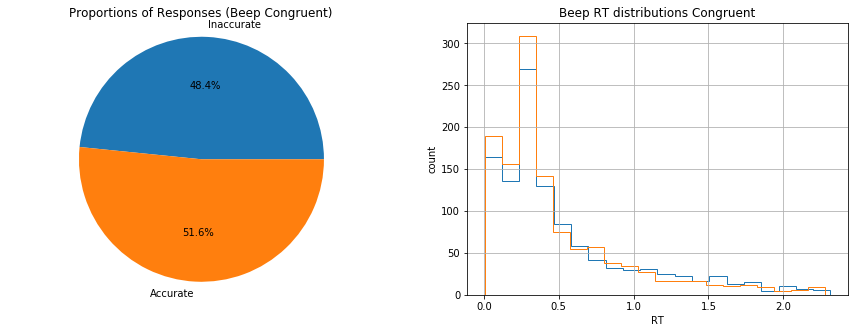

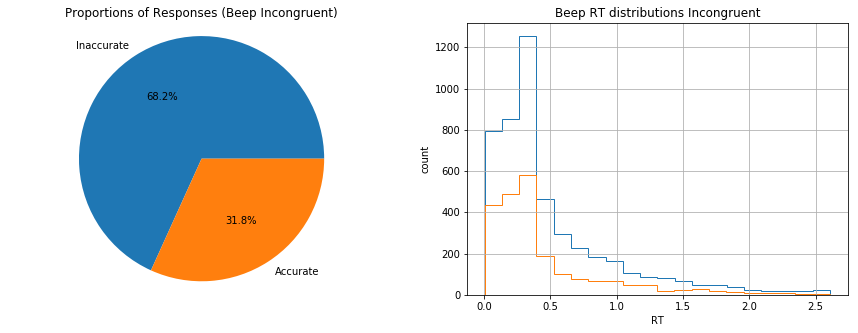

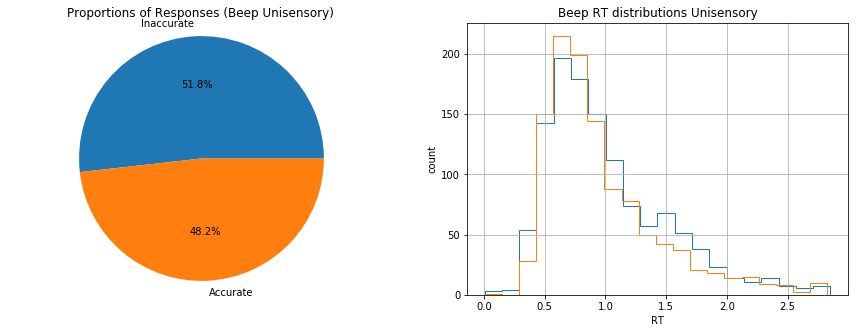

In [292]:
print(congb['response'].value_counts())
sizes = [congb['response'].value_counts()[0], congb['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig4 = plt.figure(figsize=(15, 5))
ax = fig4.add_subplot(121, title='Proportions of Responses (Beep Congruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig4.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Congruent')
for i, subj_data in congb.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

    
#print(incongbdata['response'].value_counts())
sizes = [incongb['response'].value_counts()[0], incongb['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig5 = plt.figure(figsize=(15, 5))
ax = fig5.add_subplot(121, title='Proportions of Responses (Beep Incongruent)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig5.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Incongruent')
for i, subj_data in incongb.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)
    
    
#print(unibdata['response'].value_counts())
sizes = [unib['response'].value_counts()[0], unib['response'].value_counts()[1]]
labels = ['Inaccurate', 'Accurate']

fig6 = plt.figure(figsize=(15, 5))
ax = fig6.add_subplot(121, title='Proportions of Responses (Beep Unisensory)')
ax.pie(sizes, labels = labels, autopct='%1.1f%%')
ax.axis('equal')

ax = fig6.add_subplot(122, xlabel='RT', ylabel='count', title='Beep RT distributions Unisensory')
for i, subj_data in unib.groupby('response'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

### Compare large and small incongruencies

In [29]:
smallincf = trialsf.loc[((trialsf['flashpres'] == 1) & (trialsf['beeppres'] == 2))]
smallincf = smallincf.append(trialsf.loc[((trialsf['flashpres'] == 2) & (trialsf['beeppres'] == 1))])

largeincf = trialsf.loc[(trialsf['flashpres'] == 1) & (trialsf['beeppres'] == 4)]
largeincf = largeincf.append(trialsf.loc[((trialsf['flashpres'] == 4) & (trialsf['beeppres'] == 1))])

smallincb = trialsb.loc[(trialsb['flashpres'] == 1) & (trialsb['beeppres'] == 2)]
smallincb = smallincb.append(trialsb.loc[((trialsb['flashpres'] == 2) & (trialsb['beeppres'] == 1))])

largeincb = trialsb.loc[(trialsf['flashpres'] == 1) & (trialsf['beeppres'] == 4)]
largeincb = largeincb.append(trialsb.loc[((trialsb['flashpres'] == 4) & (trialsb['beeppres'] == 1))])
# 1200 rows each

       Subj_id         rt  response  flashpres  beeppres  flashrep  beeprep
54         6.0   0.192688       1.0        1.0       4.0       1.0      3.0
57         6.0   0.280526       1.0        1.0       4.0       1.0      3.0
64         6.0   0.268792       1.0        1.0       4.0       1.0      3.0
89         6.0   0.238427       1.0        1.0       4.0       1.0      3.0
101        6.0   0.193193       1.0        1.0       4.0       1.0      3.0
108        6.0   0.067491       1.0        1.0       4.0       1.0      3.0
110        6.0   0.224967       1.0        1.0       4.0       1.0      3.0
132        6.0   0.326779       1.0        1.0       4.0       1.0      3.0
189        6.0   0.232187       0.0        1.0       4.0       2.0      3.0
238        6.0   0.083278       1.0        1.0       4.0       1.0      3.0
243        6.0   0.244926       1.0        1.0       4.0       1.0      3.0
326        6.0   0.162232       1.0        1.0       4.0       1.0      3.0
329        6